    0 = neutral,                0 - нейтральність
    1 = anger,                  1 - злість
    2 = contempt,               2 - зневага
    3 = disgust,                3 - огида 
    4 = fear,                   4 - страх
    5 = happy,                  5 - радість 
    6 = sadness,                6 - сум 
    7 = surprise                7 - здивування 

In [1]:
import os
from shutil import copy, move

import numpy as np
import pandas as pd
import dlib
import cv2

In [2]:
emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

if not os.listdir('sorted_data'):
    print('No emotions within sorted_data detected. Creating new')
    for em in emotions:
        os.makedirs('sorted_data/'+em)

In [3]:
encoded_emotions = {t: em for t, em in enumerate(emotions)}

In [4]:
encoded_emotions

{0: 'neutral',
 1: 'anger',
 2: 'contempt',
 3: 'disgust',
 4: 'fear',
 5: 'happy',
 6: 'sadness',
 7: 'surprise'}

Get all participants of the dataset

In [90]:
img_path = 'src_images'
annotations_path = 'src_labels'
destination = 'sorted_data'

raw_collector = []

participants = os.listdir(img_path)
labels = os.listdir(annotations_path)
# Map emotions with folder names
emo_map = dict(zip(emotions, [f'{k:03}' for k in range(7)]))

for person in sorted(labels):
    for emotion in os.listdir(os.path.join(annotations_path, person)):
        emotion_path = os.path.join(annotations_path, person, emotion)
        if os.listdir(emotion_path):
            with open(os.path.join(emotion_path, os.listdir(emotion_path)[0]), 'r') as f:
                sample = [os.listdir(emotion_path)[0], f.read()]
                raw_collector.append(sample)


In [48]:
import re

In [63]:
collector

[[['S005', '001', '00000011', 'emotion.txt'], 3.0],
 [['S010', '004', '00000019', 'emotion.txt'], 1.0],
 [['S010', '002', '00000014', 'emotion.txt'], 7.0],
 [['S010', '006', '00000015', 'emotion.txt'], 5.0],
 [['S011', '005', '00000020', 'emotion.txt'], 3.0],
 [['S011', '004', '00000021', 'emotion.txt'], 1.0],
 [['S011', '002', '00000022', 'emotion.txt'], 6.0],
 [['S011', '001', '00000016', 'emotion.txt'], 7.0],
 [['S011', '006', '00000013', 'emotion.txt'], 5.0],
 [['S011', '003', '00000014', 'emotion.txt'], 4.0],
 [['S014', '005', '00000017', 'emotion.txt'], 5.0],
 [['S014', '002', '00000016', 'emotion.txt'], 6.0],
 [['S014', '001', '00000029', 'emotion.txt'], 7.0],
 [['S014', '003', '00000030', 'emotion.txt'], 1.0],
 [['S022', '005', '00000032', 'emotion.txt'], 1.0],
 [['S022', '001', '00000030', 'emotion.txt'], 7.0],
 [['S022', '006', '00000017', 'emotion.txt'], 3.0],
 [['S026', '002', '00000016', 'emotion.txt'], 6.0],
 [['S026', '001', '00000015', 'emotion.txt'], 7.0],
 [['S026', '

In [82]:
collector = []

for filename, emotion in raw_collector:
    file_metadata = filename.split('_')
    emotion = float(emotion.replace(' ', '').replace('e+00\n', ''))
    collector.append([file_metadata, emotion])

##### Create a backup

In [65]:
with open('backup_0.csv', 'w') as f:
    f.write(str(collector).replace('.0],', '\n').replace('[', '').replace(']', ''))

#### Move images to appropriate folders

In [91]:
for [person, collection, img, ll], label in collector:
    # Such a shit :)
    assert label > 0, f'{person, collection} has neutral ({label}) label'
    
    path_to_img_folder = os.path.join(img_path, person, collection)
    
    images = sorted(os.listdir(path_to_img_folder))
    # First 20% of images are neutral. The last (suppose 50%) are emotional.
    n = len(images)
    for i, image in enumerate(images, 1):
        img_with_path = os.path.join(path_to_img_folder, image)
        # Mark first 20% of images as neutral
        if i / n <= 0.2:
            copy(img_with_path, os.path.join(destination, encoded_emotions[0], image))
        elif i / n >= 0.5:
            copy(img_with_path, os.path.join(destination, encoded_emotions[int(label)], image))
        # Mark last 50% of images as not neutral
        #print(img_with_path, label, encoded_emotions[int(label)], round(100 * i / n, 2))
    

Now go to folders & throw out some images manually (especially from the neutral folder)



After that pass all the images through the dlib keypoint detector to get all the facial points

In [298]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../face_landmarks.dat')


def shape_to_np(shape, dtype="int", landmarks_count=68):
    point = np.zeros((landmarks_count, 2), dtype=dtype)

    for i in range(landmarks_count):
        point[i] = (shape.part(i).x, shape.part(i).y)
    return point


def get_normalized_coords(shape, w, h):
    face_landmarks = []

    x_c, y_c = np.mean(shape, axis=0)
    for x, y in shape:
        face_landmarks.append([(x_c - x) / w, (y_c - y) / h])
    return np.array(face_landmarks)


def get_radius_vector(shape, w, h):
    rad_vec = []
    x_c, y_c = np.mean(shape, axis=0)
    for x, y in shape:
            rad_vec.append(np.sqrt(np.square((x_c - x) / w) + np.square((y_c - y) / h)))
    return rad_vec


def get_face_landmarks(img_name, img_array, predictor):
    gray_image = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    w, h = img_array.shape[:2]
    rects = detector(gray_image, 1)
#     rad_vectors = []
#     face_landmarks = []
    for i, rect in enumerate(rects):
        if i > 1:
            print(f'{img_name} seems to fail')
            break
        face_detector = predictor(gray_image, rect)
        shape = shape_to_np(face_detector)
      
       # face_landmarks.append()
       # rad_vectors.append()
        return get_normalized_coords(shape, w, h), get_radius_vector(shape, w, h)




In [299]:
!pip install atpbar
from atpbar import atpbar

You are using pip version 9.0.3, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
jsonlike = []
for emotion in atpbar(emotions, name='images'):
    for image in atpbar(os.listdir(os.path.join(destination, emotion)), name=emotion):
        imgpath = os.path.join(destination, emotion, image)
        try:
            img_array = cv2.imread(imgpath)
            face_landmarks, rad_vectors = get_face_landmarks(image, img_array, predictor)
        except:
            print(f'failed on {imgpath}')
            continue
        
        current_image_collector = {'image': image, 'emotion': emotion}

        
        #print(face_landmarks[0])
        
        for i, [x, y] in enumerate(face_landmarks):
            current_image_collector.update({f'landmark_{i}_x':x})
            current_image_collector.update({f'landmark_{i}_y':y})
            current_image_collector.update({f'landmark_{i}_r':rad_vectors[i]})
        jsonlike.append(current_image_collector)

        
        


VBox()

failed on sorted_data/neutral/S044_003_00000001.png
failed on sorted_data/neutral/S056_004_00000001.png
failed on sorted_data/neutral/S050_006_00000001.png
failed on sorted_data/neutral/S135_001_00000003.png
failed on sorted_data/neutral/S082_005_00000001.png
failed on sorted_data/neutral/S098_003_00000002.png
failed on sorted_data/neutral/S096_003_00000002.png
failed on sorted_data/neutral/S108_005_00000001.png
failed on sorted_data/neutral/S160_006_00000002.png
failed on sorted_data/neutral/S501_004_00000011.png
failed on sorted_data/neutral/S066_004_00000001.png
failed on sorted_data/neutral/S124_003_00000001.png
failed on sorted_data/neutral/S501_001_00000009.png
failed on sorted_data/neutral/S108_006_00000003.png
failed on sorted_data/neutral/S126_004_00000001.png
failed on sorted_data/neutral/S055_001_00000002.png
failed on sorted_data/neutral/S078_001_00000005.png
failed on sorted_data/neutral/S116_001_00000002.png
failed on sorted_data/neutral/S127_004_00000002.png


KeyboardInterrupt: 



ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [5]:
df2 = pd.read_csv('data2.csv')

In [10]:
df2.head()

,Unnamed: 0,emotion,image,landmark_0_r,landmark_0_x,landmark_0_y,landmark_10_r,landmark_10_x,landmark_10_y,landmark_11_r,...,landmark_6_y,landmark_7_r,landmark_7_x,landmark_7_y,landmark_8_r,landmark_8_x,landmark_8_y,landmark_9_r,landmark_9_x,landmark_9_y
0,0,neutral,S064_004_00000001.png,0.271145,0.251200,0.102068,0.194871,-0.105942,-0.163557,0.191921,...,-0.165119,0.204039,0.065486,-0.193244,0.201102,0.004262,-0.201057,0.203547,-0.059004,-0.194807
1,1,neutral,S034_003_00000004.png,0.201241,0.192197,0.059651,0.170787,-0.105762,-0.134099,0.180420,...,-0.135662,0.157286,0.037095,-0.152849,0.156426,-0.011885,-0.155974,0.163071,-0.060864,-0.151287
2,2,neutral,S071_006_00000002.png,0.240299,0.226951,0.078975,0.182808,-0.105702,-0.149150,0.195176,...,-0.147587,0.176654,0.063685,-0.164775,0.171084,0.004502,-0.171025,0.175095,-0.054682,-0.166337
3,3,neutral,S075_008_00000001.png,0.290074,0.274640,0.093359,0.220506,-0.129442,-0.178516,0.225822,...,-0.180078,0.221178,0.074640,-0.208203,0.217581,0.001170,-0.217578,0.221077,-0.074340,-0.208203
4,4,neutral,S134_004_00000003.png,0.244286,0.234004,0.070129,0.199136,-0.125180,-0.154871,0.215398,...,-0.159559,0.185543,0.056453,-0.176746,0.183123,-0.006813,-0.182996,0.188004,-0.072119,-0.173621


In [ ]:
df3 = pd.DataFrame(jsonlike)

In [ ]:
df3.sample(20)

In [251]:
df3.to_csv('data3.csv')

In [ ]:
df2 = pd.DataFrame(jsonlike)

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4171 entries, 0 to 4170
Columns: 207 entries, Unnamed: 0 to landmark_9_y
dtypes: float64(204), int64(1), object(2)
memory usage: 6.6+ MB


In [9]:
df2.describe()

,Unnamed: 0,landmark_0_r,landmark_0_x,landmark_0_y,landmark_10_r,landmark_10_x,landmark_10_y,landmark_11_r,landmark_11_x,landmark_11_y,...,landmark_6_y,landmark_7_r,landmark_7_x,landmark_7_y,landmark_8_r,landmark_8_x,landmark_8_y,landmark_9_r,landmark_9_x,landmark_9_y
count,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,...,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000
mean,2085.000000,0.254656,0.239771,0.084503,0.202889,-0.121692,-0.161728,0.213209,-0.168165,-0.130311,...,-0.163825,0.195978,0.058697,-0.186559,0.193425,-0.004470,-0.193088,0.197747,-0.067805,-0.185362
std,1204.208315,0.027846,0.027654,0.015148,0.021093,0.017186,0.018662,0.023118,0.022376,0.015211,...,0.018870,0.021736,0.012726,0.021638,0.022808,0.010553,0.022785,0.021960,0.012837,0.021561
min,0.000000,0.186321,0.169358,0.035363,0.141248,-0.181693,-0.224127,0.146436,-0.235846,-0.185968,...,-0.229596,0.146853,0.016867,-0.265533,0.141107,-0.053812,-0.278814,0.141985,-0.127281,-0.264752
25%,1042.500000,0.239121,0.224070,0.075620,0.188895,-0.130567,-0.172004,0.198570,-0.178526,-0.138477,...,-0.174713,0.182063,0.050180,-0.199954,0.177912,-0.009844,-0.205296,0.183461,-0.074910,-0.197484
50%,2085.000000,0.252748,0.237995,0.084375,0.203020,-0.120438,-0.159681,0.212852,-0.166116,-0.129573,...,-0.161236,0.193581,0.058313,-0.183938,0.190403,-0.004292,-0.190211,0.195051,-0.067341,-0.182812
75%,3127.500000,0.270895,0.252671,0.094193,0.215565,-0.109289,-0.150483,0.224819,-0.152866,-0.121002,...,-0.151297,0.208525,0.067768,-0.171622,0.205821,0.002161,-0.177654,0.211831,-0.059319,-0.171140
max,4170.000000,0.348364,0.327491,0.137500,0.276020,-0.068127,-0.118405,0.285508,-0.100780,-0.091544,...,-0.117119,0.271214,0.090778,-0.134306,0.279441,0.023199,-0.140556,0.282408,-0.029352,-0.136765


In [281]:
df2 = df2.sample(frac=1)

In [17]:
df2.head()

,landmark_0_r,landmark_0_x,landmark_0_y,landmark_10_r,landmark_10_x,landmark_10_y,landmark_11_r,landmark_11_x,landmark_11_y,landmark_12_r,...,landmark_6_y,landmark_7_r,landmark_7_x,landmark_7_y,landmark_8_r,landmark_8_x,landmark_8_y,landmark_9_r,landmark_9_x,landmark_9_y
0,0.271145,0.251200,0.102068,0.194871,-0.105942,-0.163557,0.191921,-0.144718,-0.126057,0.194357,...,-0.165119,0.204039,0.065486,-0.193244,0.201102,0.004262,-0.201057,0.203547,-0.059004,-0.194807
1,0.201241,0.192197,0.059651,0.170787,-0.105762,-0.134099,0.180420,-0.142497,-0.110662,0.186753,...,-0.135662,0.157286,0.037095,-0.152849,0.156426,-0.011885,-0.155974,0.163071,-0.060864,-0.151287
2,0.240299,0.226951,0.078975,0.182808,-0.105702,-0.149150,0.195176,-0.150600,-0.124150,0.202930,...,-0.147587,0.176654,0.063685,-0.164775,0.171084,0.004502,-0.171025,0.175095,-0.054682,-0.166337
3,0.290074,0.274640,0.093359,0.220506,-0.129442,-0.178516,0.225822,-0.176381,-0.141016,0.228706,...,-0.180078,0.221178,0.074640,-0.208203,0.217581,0.001170,-0.217578,0.221077,-0.074340,-0.208203
4,0.244286,0.234004,0.070129,0.199136,-0.125180,-0.154871,0.215398,-0.174160,-0.126746,0.227145,...,-0.159559,0.185543,0.056453,-0.176746,0.183123,-0.006813,-0.182996,0.188004,-0.072119,-0.173621


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle

In [14]:
from sklearn.svm import SVC

In [11]:
label = df2['emotion']

In [15]:
le = LabelEncoder()
y = le.fit_transform(label)

In [16]:
df2 = df2.drop(['emotion', 'image', 'Unnamed: 0'], axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.2)

In [19]:
svm = SVC(kernel='linear')

In [20]:
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [21]:
y_pred = svm.predict(X_test)

In [41]:
sum(y_pred == y_test) / len(y_test)

0.9461077844311377

In [23]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [24]:

model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [25]:
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [26]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [27]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
pickle.dump(model, open('xgb_with.pickle', 'wb'))

Accuracy: 94.61%


In [31]:
restored = pickle.load(open("xgb_with.pickle", "rb"))

In [40]:
rand_weights = list(X_test.iterrows())[1][1]

### Restoring the original point coordinates

In [78]:
x_c = 100
y_c = 100
w = 200
h = 200

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.4 µs


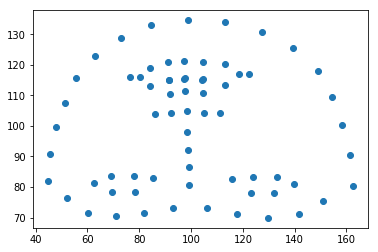

In [80]:
%time

shape = []
for k in range(0, len(rand_weights), 3):
    x = x_c - w * rand_weights[k+1] 
    y = y_c - h * rand_weights[k+2]
    shape.append([x, y])
x_s = [s[0] for s in shape]
y_s = [s[1] for s in shape]

plt.scatter(x_s, y_s)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 12.2 µs


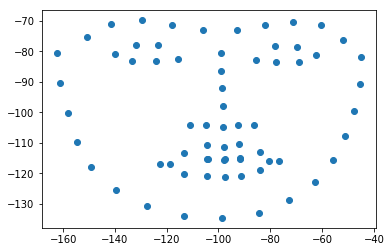

In [82]:
%time

rand_ar = np.array(rand_weights).reshape(68,3)
rand_ar = np.delete(rand_ar, obj=0, axis=1)

rand_ar[:,0] = - x_c + w * rand_ar[:,0]
rand_ar[:,1] = - y_c + h * rand_ar[:,1]

plt.scatter(rand_ar[:,0], rand_ar[:,1])

In [83]:
def restore_coordinates(norm_shape, x_c, y_c, w, h):
    shape = np.array(norm_shape).reshape(68,3)
    shape = np.delete(shape, obj=0, axis=1)

    shape[:,0] = - x_c + w * rand_ar[:,0]
    shape[:,1] = - y_c + h * rand_ar[:,1]
    return shape

In [94]:
model.predict(np.array(rand_weights).reshape([204, 1]))

ValueError: feature_names mismatch: ['landmark_0_r', 'landmark_0_x', 'landmark_0_y', 'landmark_10_r', 'landmark_10_x', 'landmark_10_y', 'landmark_11_r', 'landmark_11_x', 'landmark_11_y', 'landmark_12_r', 'landmark_12_x', 'landmark_12_y', 'landmark_13_r', 'landmark_13_x', 'landmark_13_y', 'landmark_14_r', 'landmark_14_x', 'landmark_14_y', 'landmark_15_r', 'landmark_15_x', 'landmark_15_y', 'landmark_16_r', 'landmark_16_x', 'landmark_16_y', 'landmark_17_r', 'landmark_17_x', 'landmark_17_y', 'landmark_18_r', 'landmark_18_x', 'landmark_18_y', 'landmark_19_r', 'landmark_19_x', 'landmark_19_y', 'landmark_1_r', 'landmark_1_x', 'landmark_1_y', 'landmark_20_r', 'landmark_20_x', 'landmark_20_y', 'landmark_21_r', 'landmark_21_x', 'landmark_21_y', 'landmark_22_r', 'landmark_22_x', 'landmark_22_y', 'landmark_23_r', 'landmark_23_x', 'landmark_23_y', 'landmark_24_r', 'landmark_24_x', 'landmark_24_y', 'landmark_25_r', 'landmark_25_x', 'landmark_25_y', 'landmark_26_r', 'landmark_26_x', 'landmark_26_y', 'landmark_27_r', 'landmark_27_x', 'landmark_27_y', 'landmark_28_r', 'landmark_28_x', 'landmark_28_y', 'landmark_29_r', 'landmark_29_x', 'landmark_29_y', 'landmark_2_r', 'landmark_2_x', 'landmark_2_y', 'landmark_30_r', 'landmark_30_x', 'landmark_30_y', 'landmark_31_r', 'landmark_31_x', 'landmark_31_y', 'landmark_32_r', 'landmark_32_x', 'landmark_32_y', 'landmark_33_r', 'landmark_33_x', 'landmark_33_y', 'landmark_34_r', 'landmark_34_x', 'landmark_34_y', 'landmark_35_r', 'landmark_35_x', 'landmark_35_y', 'landmark_36_r', 'landmark_36_x', 'landmark_36_y', 'landmark_37_r', 'landmark_37_x', 'landmark_37_y', 'landmark_38_r', 'landmark_38_x', 'landmark_38_y', 'landmark_39_r', 'landmark_39_x', 'landmark_39_y', 'landmark_3_r', 'landmark_3_x', 'landmark_3_y', 'landmark_40_r', 'landmark_40_x', 'landmark_40_y', 'landmark_41_r', 'landmark_41_x', 'landmark_41_y', 'landmark_42_r', 'landmark_42_x', 'landmark_42_y', 'landmark_43_r', 'landmark_43_x', 'landmark_43_y', 'landmark_44_r', 'landmark_44_x', 'landmark_44_y', 'landmark_45_r', 'landmark_45_x', 'landmark_45_y', 'landmark_46_r', 'landmark_46_x', 'landmark_46_y', 'landmark_47_r', 'landmark_47_x', 'landmark_47_y', 'landmark_48_r', 'landmark_48_x', 'landmark_48_y', 'landmark_49_r', 'landmark_49_x', 'landmark_49_y', 'landmark_4_r', 'landmark_4_x', 'landmark_4_y', 'landmark_50_r', 'landmark_50_x', 'landmark_50_y', 'landmark_51_r', 'landmark_51_x', 'landmark_51_y', 'landmark_52_r', 'landmark_52_x', 'landmark_52_y', 'landmark_53_r', 'landmark_53_x', 'landmark_53_y', 'landmark_54_r', 'landmark_54_x', 'landmark_54_y', 'landmark_55_r', 'landmark_55_x', 'landmark_55_y', 'landmark_56_r', 'landmark_56_x', 'landmark_56_y', 'landmark_57_r', 'landmark_57_x', 'landmark_57_y', 'landmark_58_r', 'landmark_58_x', 'landmark_58_y', 'landmark_59_r', 'landmark_59_x', 'landmark_59_y', 'landmark_5_r', 'landmark_5_x', 'landmark_5_y', 'landmark_60_r', 'landmark_60_x', 'landmark_60_y', 'landmark_61_r', 'landmark_61_x', 'landmark_61_y', 'landmark_62_r', 'landmark_62_x', 'landmark_62_y', 'landmark_63_r', 'landmark_63_x', 'landmark_63_y', 'landmark_64_r', 'landmark_64_x', 'landmark_64_y', 'landmark_65_r', 'landmark_65_x', 'landmark_65_y', 'landmark_66_r', 'landmark_66_x', 'landmark_66_y', 'landmark_67_r', 'landmark_67_x', 'landmark_67_y', 'landmark_6_r', 'landmark_6_x', 'landmark_6_y', 'landmark_7_r', 'landmark_7_x', 'landmark_7_y', 'landmark_8_r', 'landmark_8_x', 'landmark_8_y', 'landmark_9_r', 'landmark_9_x', 'landmark_9_y'] ['f0']
expected landmark_39_y, landmark_44_y, landmark_19_y, landmark_24_r, landmark_28_x, landmark_2_x, landmark_48_r, landmark_57_x, landmark_15_r, landmark_13_r, landmark_30_x, landmark_61_y, landmark_9_r, landmark_51_y, landmark_19_x, landmark_34_x, landmark_7_x, landmark_3_y, landmark_4_x, landmark_64_r, landmark_36_r, landmark_41_x, landmark_46_x, landmark_3_r, landmark_21_x, landmark_40_r, landmark_5_r, landmark_1_x, landmark_31_r, landmark_49_y, landmark_60_r, landmark_10_x, landmark_36_y, landmark_53_r, landmark_42_x, landmark_38_r, landmark_22_r, landmark_55_r, landmark_45_r, landmark_3_x, landmark_65_r, landmark_8_y, landmark_48_y, landmark_65_x, landmark_5_y, landmark_14_x, landmark_28_r, landmark_12_y, landmark_6_r, landmark_59_x, landmark_56_x, landmark_66_x, landmark_6_y, landmark_7_r, landmark_47_r, landmark_61_r, landmark_21_y, landmark_24_y, landmark_12_r, landmark_31_x, landmark_54_y, landmark_30_y, landmark_64_x, landmark_10_y, landmark_8_x, landmark_15_x, landmark_46_y, landmark_13_y, landmark_29_r, landmark_26_y, landmark_33_r, landmark_25_r, landmark_35_y, landmark_37_x, landmark_43_r, landmark_52_y, landmark_16_r, landmark_24_x, landmark_11_r, landmark_63_y, landmark_35_r, landmark_17_y, landmark_29_x, landmark_6_x, landmark_51_r, landmark_52_r, landmark_57_y, landmark_14_y, landmark_58_y, landmark_39_r, landmark_20_x, landmark_27_y, landmark_15_y, landmark_48_x, landmark_55_x, landmark_27_x, landmark_31_y, landmark_49_x, landmark_59_y, landmark_7_y, landmark_43_x, landmark_66_r, landmark_26_x, landmark_67_r, landmark_36_x, landmark_4_y, landmark_5_x, landmark_19_r, landmark_67_y, landmark_18_r, landmark_0_r, landmark_57_r, landmark_17_r, landmark_37_y, landmark_47_x, landmark_18_y, landmark_62_y, landmark_47_y, landmark_33_y, landmark_67_x, landmark_2_r, landmark_17_x, landmark_32_x, landmark_41_r, landmark_53_y, landmark_63_x, landmark_18_x, landmark_45_y, landmark_54_r, landmark_14_r, landmark_30_r, landmark_38_x, landmark_39_x, landmark_22_y, landmark_2_y, landmark_65_y, landmark_46_r, landmark_62_x, landmark_13_x, landmark_59_r, landmark_23_y, landmark_42_r, landmark_42_y, landmark_43_y, landmark_54_x, landmark_38_y, landmark_23_r, landmark_32_y, landmark_40_x, landmark_60_x, landmark_26_r, landmark_33_x, landmark_23_x, landmark_56_r, landmark_20_y, landmark_45_x, landmark_28_y, landmark_41_y, landmark_60_y, landmark_10_r, landmark_22_x, landmark_49_r, landmark_51_x, landmark_53_x, landmark_9_y, landmark_50_r, landmark_34_y, landmark_9_x, landmark_1_y, landmark_11_y, landmark_58_x, landmark_63_r, landmark_25_y, landmark_35_x, landmark_12_x, landmark_11_x, landmark_40_y, landmark_50_x, landmark_61_x, landmark_66_y, landmark_58_r, landmark_50_y, landmark_21_r, landmark_29_y, landmark_55_y, landmark_27_r, landmark_8_r, landmark_64_y, landmark_52_x, landmark_37_r, landmark_34_r, landmark_16_x, landmark_1_r, landmark_62_r, landmark_32_r, landmark_16_y, landmark_44_r, landmark_44_x, landmark_4_r, landmark_0_y, landmark_20_r, landmark_56_y, landmark_0_x, landmark_25_x in input data
training data did not have the following fields: f0